# Importamos las librerias a usar

In [243]:
# !pip3 install --upgrade wandb

In [244]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sklearn
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special

In [245]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from scipy.special import j0, y0

In [246]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

True

In [247]:
# lr = "NA" #Learning rate
# epochs = 500
# bs = "NA" #batch size
# loss = "mse"
# optimizer = "SDG"
# regularizer = "NA"

In [248]:
# run = wandb.init(
#     settings=wandb.Settings(x_disable_stats=False, x_stats_sampling_interval = 25),
#     # set the wandb project where this run will be logged
#     name = "Primer_Intento",
#     project = "Creacion_de_regresion_lineal",
#     group = "ODE_SOLVER_B",

#     # track hyperparameters and run metadata with wandb.config
#     config = {
#         "layer_1": "100",
#         "layer_2": "20",
#         "layer_3": "1",
#         "activation_1_2": "tanh",
#         "activation_3": "linear",
#         "w_initializer": "He Initialization",
#         "optimizer": optimizer,
#         "loss": loss,
#         "metric": "mse",
#         "epoch": epochs,
#         "batch_size": bs,
#         "layer_quantity": 3,
#         "regularizer": regularizer,
#         "Modelo": "ODE"
#     }
# )
# time.sleep(3.0)

# Preparación

La solución de la ec. diferencial es y(x) = x*sen(x) - (2*sen(x))/x + 2*cos(x) + C/x, para valores muy pequeños de x tenemos y(x) = x^2 - 2x/x + 2 + C/x = x^2 + C/x si hacemos C = 0 entonces y(0) = 0 para valores pequeños de x. de otro modo en 0 la solución se va a infinito en 0. Ppor otro lado para evitar problemas de entrenamiento en la red aproximaremos el x_0<<1 y no a 0.

## Creamos la clase para resolver la ecuación diferencial

In [249]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min_val = tf.cast(tf.reduce_min(data),tf.float32)
         max_val = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min_val, maxval=max_val)

         with tf.GradientTape(persistent = True) as tape:
             tape.watch(x)
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             ddy = tape.gradient(dy, x)
             
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
        
             with tf.GradientTape() as tape3:
                 tape3.watch(x_o)
                 y_o_tape = self(x_o, training = True)
             dy_o = tape3.gradient(y_o_tape, x_o)
             eq = x*ddy + y_pred #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic1 = 0.1
             ic2 = -0.5
             loss = self.mse(0., eq) + self.mse(y_o,ic1) + self.mse(dy_o,ic2)

        # Apply grads
         trainable_vars = self.trainable_variables 
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
         del tape
         return {"loss": self.loss_tracker.result()}

# Creación de la red neuronal

In [250]:
model = ODEsolver()
model.add(Dense(100, activation='tanh', input_shape=(1,)))
model.add(Dense(100, activation='tanh'))
model.add(Dense((50), activation="tanh"))
model.add(Dense(1))
model.summary()

Model: "od_esolver_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,401 (60.16 KB)

 Trainable params: 15,401 (60.16 KB)

 Non-trainable params: 0 (0.00 B)

## Observamos el comportamiento del loss

Epoch 1/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0522
Epoch 2/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0197
Epoch 3/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146
Epoch 4/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125
Epoch 5/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114
Epoch 6/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099
Epoch 7/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094
Epoch 8/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087
Epoch 9/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081
Epoch 10/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077
Epoch 11/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072
Epoch 12/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073
Epoch 13/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0067
Epoch 14/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062
Epoch 15/1000
313/313 ━━━━━━━

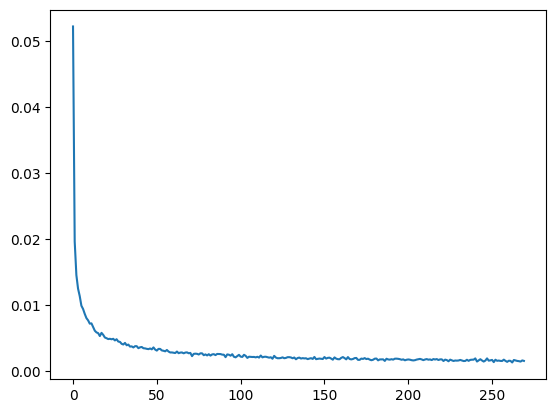

In [251]:
model.compile(optimizer=RMSprop(),metrics=['loss'])
divisions = 10000
x = tf.linspace(-5,5,divisions)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                               min_delta = 0.001,
                               patience=150, 
                               restore_best_weights=True,
                               mode = "auto",
                               verbose = 1,
                               baseline = None)
history = model.fit(x, 
                    epochs = 1000, 
                    verbose = 1, 
                    callbacks=[
                        # WandbMetricsLogger(log_freq=25),
                        # WandbModelCheckpoint("models/model.keras"),
                        early_stopping
                    ])
# run.finish()
plt.plot(history.history["loss"])

## Visualizamos

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step


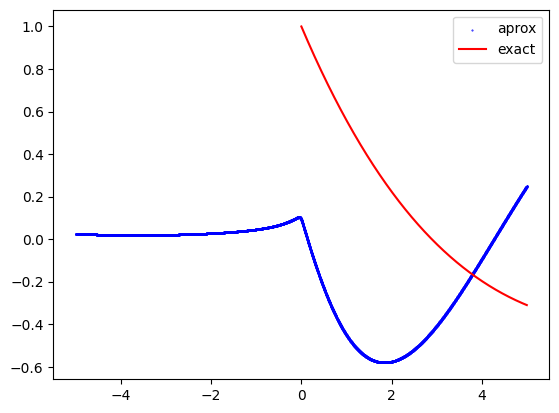

In [252]:
def y(x, C1=1.0, C2=0.0):
    return C1 * special.j0(np.sqrt(2 * x)) + C2 * special.y0(np.sqrt(2 * x))


x_testv = tf.linspace(-5,5,divisions)
x = x_testv
a=model.predict(x_testv)
plt.scatter(x_testv,a,label="aprox", s = 0.2, color = "blue")
plt.plot(x_testv, y(x),label="exact", color = "red")
plt.legend()
plt.show()
